![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# В начале идет осмотр данных, вся обработка параметров спрятана в def preproc_data(df_input):

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from datetime import datetime, timedelta
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
31316,id_12349,London,"['Chinese', 'Asian', 'Thai']",12359.0,4.0,NaN,NaN,"[['Good, big portions, slow delivery'], ['11/2...",/Restaurant_Review-g186338-d8841968-Reviews-Ho...,d8841968
6413,id_3112,London,"['Japanese', 'Asian', 'Sushi', 'Vegetarian Fri...",3118.0,4.0,$$ - $$$,166.0,"[['Vegan Japanese - a must for all vegan/veg',...",/Restaurant_Review-g186338-d2011629-Reviews-It...,d2011629
17919,id_2820,Prague,NaN,2826.0,4.0,NaN,4.0,"[['Pub/restaurant in a castle gatehouse'], ['1...",/Restaurant_Review-g274707-d11749706-Reviews-D...,d11749706
20855,id_4206,London,"['Cafe', 'Vegetarian Friendly', 'Vegan Options...",4213.0,4.0,$$ - $$$,55.0,"[['Turn it down or off', 'Waiting with Wi-Fi']...",/Restaurant_Review-g186338-d10357537-Reviews-B...,d10357537
36960,id_2950,London,"['Italian', 'Pizza', 'Vegetarian Friendly', 'V...",2956.0,4.0,$$ - $$$,430.0,"[['Lovely atmosphere', 'Traditional Restaurant...",/Restaurant_Review-g186338-d734306-Reviews-Tra...,d734306


In [6]:
df_test.info()
df_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
9934,id_9934,Barcelona,"['Cafe', 'Mediterranean', 'European', 'Healthy...",2390.0,$,11.0,"[['Nice !!!', 'Best bagels in town'], ['06/20/...",/Restaurant_Review-g187497-d12424469-Reviews-C...,d12424469
531,id_531,Madrid,"['European', 'Spanish', 'Mediterranean']",1494.0,$$ - $$$,309.0,"[['Madrid', 'Very positive NO'], ['02/26/2017'...",/Restaurant_Review-g187514-d3748874-Reviews-NO...,d3748874
4005,id_4005,Milan,"['Italian', 'Seafood', 'Mediterranean']",1127.0,$$ - $$$,243.0,"[['Tasty seafood, nice atmosphere and excelle....",/Restaurant_Review-g187849-d2316329-Reviews-La...,d2316329
7275,id_7275,Stockholm,"['Mediterranean', 'Italian', 'Pizza', 'Vegetar...",549.0,$$ - $$$,290.0,"[[""Great food, didn't like staff"", 'Vapiano Vi...",/Restaurant_Review-g189852-d4590820-Reviews-Va...,d4590820
1498,id_1498,Prague,['Cafe'],1879.0,NaN,3.0,"[[], []]",/Restaurant_Review-g274707-d7123464-Reviews-Pe...,d7123464


In [7]:
sample_submission.info()
sample_submission.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
5329,id_5329,4.5
1102,id_1102,5.0
1632,id_1632,5.0
213,id_213,2.0
7705,id_7705,3.0


In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [9]:
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
46262,id_8806,Paris,['Italian'],8808.0,$$ - $$$,25.0,"[['Small but so good', 'Awesome food , must tr...",/Restaurant_Review-g187147-d3907854-Reviews-Le...,d3907854,1,4.0
1232,id_1232,Madrid,NaN,8751.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d9809531-Reviews-La...,d9809531,0,0.0
38167,id_1160,Hamburg,['Seafood'],1162.0,$$ - $$$,28.0,"[['Nice food soft tasty wine but...', 'Nice Sn...",/Restaurant_Review-g187331-d2050128-Reviews-Oy...,d2050128,1,4.0
44133,id_1877,Berlin,"['Bar', 'Pub']",1879.0,$$ - $$$,33.0,"[['Great place to hang out', 'Music is in the ...",/Restaurant_Review-g187323-d8562012-Reviews-En...,d8562012,1,4.0
23219,id_96,Hamburg,"['Asian', 'Fusion', 'Vietnamese', 'Vegetarian ...",97.0,$,59.0,"[['Amazing Duck Curry!', 'Nom-ilicious, super ...",/Restaurant_Review-g187331-d12732323-Reviews-N...,d12732323,1,5.0


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [10]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [11]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [12]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [13]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [14]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [15]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [16]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
47755,id_2010,"['Bar', 'Pub', 'French']",2011.0,$$ - $$$,38.0,"[['Nice cool cute place'], ['03/12/2016']]",/Restaurant_Review-g207360-d4942337-Reviews-Br...,d4942337,1,3.0,...,0,0,0,0,0,0,0,0,0,0
34398,id_1847,['Russian'],1850.0,$$ - $$$,13.0,"[['Pleasant restaurant, nice service, unusual....",/Restaurant_Review-g274707-d7123677-Reviews-So...,d7123677,1,4.5,...,0,0,0,1,0,0,0,0,0,0
29714,id_12654,NaN,12664.0,NaN,0.0,"[['Do one thing, do it very well'], ['01/14/20...",/Restaurant_Review-g186338-d11953811-Reviews-M...,d11953811,1,4.0,...,0,0,0,0,0,0,0,0,0,0
29014,id_11959,"['Pizza', 'Italian']",11961.0,$$ - $$$,19.0,"[['Great little spot ............', 'friendly ...",/Restaurant_Review-g187147-d4301853-Reviews-Ca...,d4301853,1,3.5,...,0,0,1,0,0,0,0,0,0,0
39302,id_5809,"['Italian', 'Mediterranean']",5811.0,NaN,0.0,"[[], []]",/Restaurant_Review-g187791-d8354043-Reviews-La...,d8354043,1,5.0,...,0,0,0,0,1,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [17]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

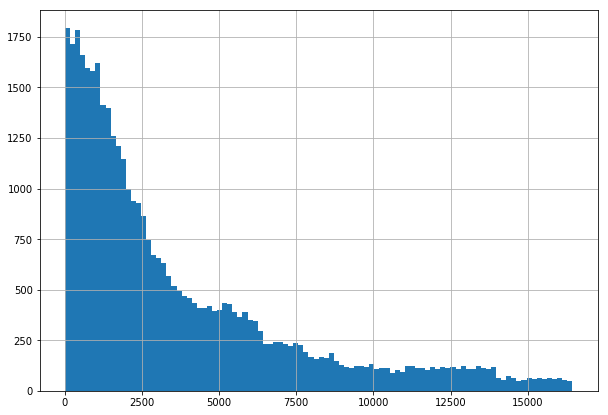

In [18]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

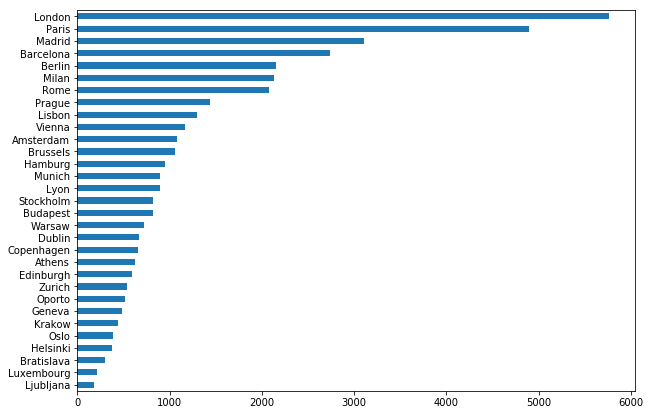

In [19]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

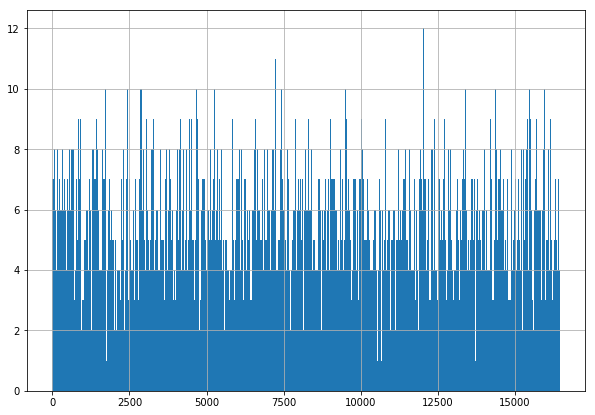

In [20]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=1000)

In [21]:
df_train['Ranking'][(df_train['City'] =='London')&(df_train['Ranking'] < 20)]

4046      6.0
5936      1.0
6818     17.0
8125     13.0
8447     18.0
16197    10.0
31341    16.0
37013    11.0
Name: Ranking, dtype: float64

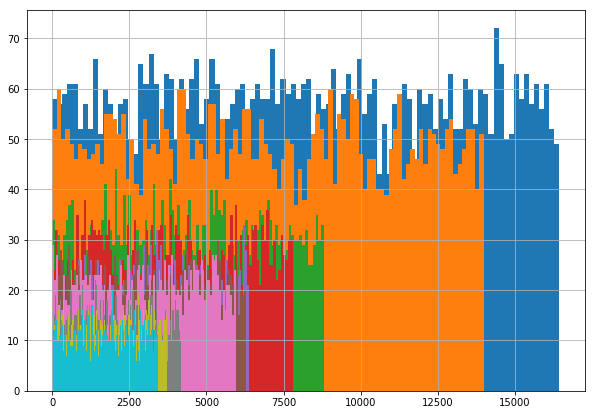

In [22]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [23]:
# как вариант, можно отнормировать ранг ресторанов по городам или на наеление города, больше ниже
mean_Ranking_on_City = df_train.groupby(['City'])['Ranking'].mean()
max_Ranking_on_City = df_train.groupby(['City'])['Ranking'].max()
df_train['max_Ranking_on_City'] = df_train['City'].apply(lambda x: max_Ranking_on_City[x])
df_train['mean_Ranking_on_City'] = df_train['City'].apply(lambda x: mean_Ranking_on_City[x])
#df_train['norm_Ranking_on_maxRank_in_City'] = (df_train['Ranking'] - df_train['mean_Ranking_on_City']) / (df_train['max_Ranking_on_City']-df_train['mean_Ranking_on_City'])
df_train['norm_Ranking_on_maxRank_in_City'] = (df_train['Ranking']) / (df_train['max_Ranking_on_City'])

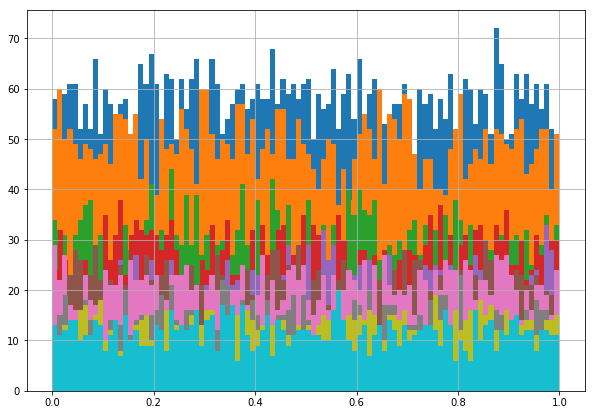

In [24]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['norm_Ranking_on_maxRank_in_City'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

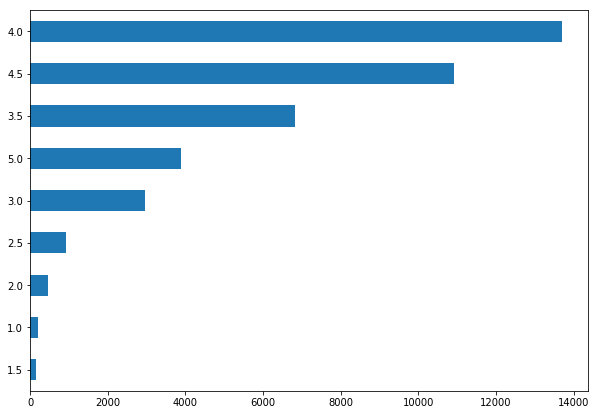

In [25]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

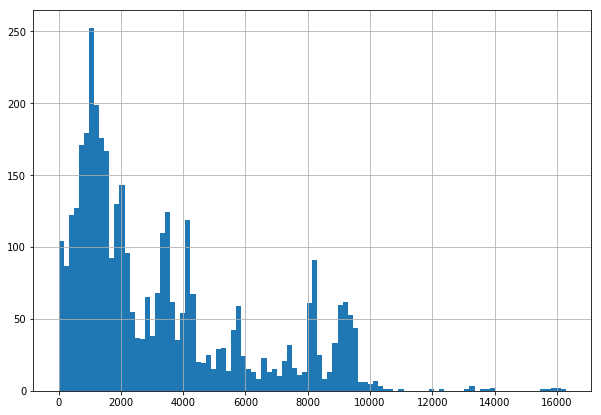

In [26]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

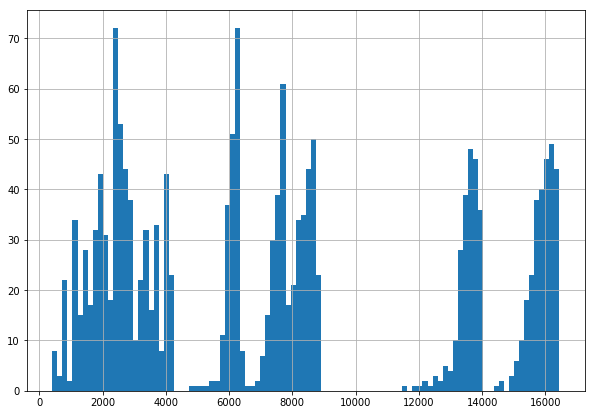

In [27]:
df_train['Ranking'][df_train['Rating'] < 3].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

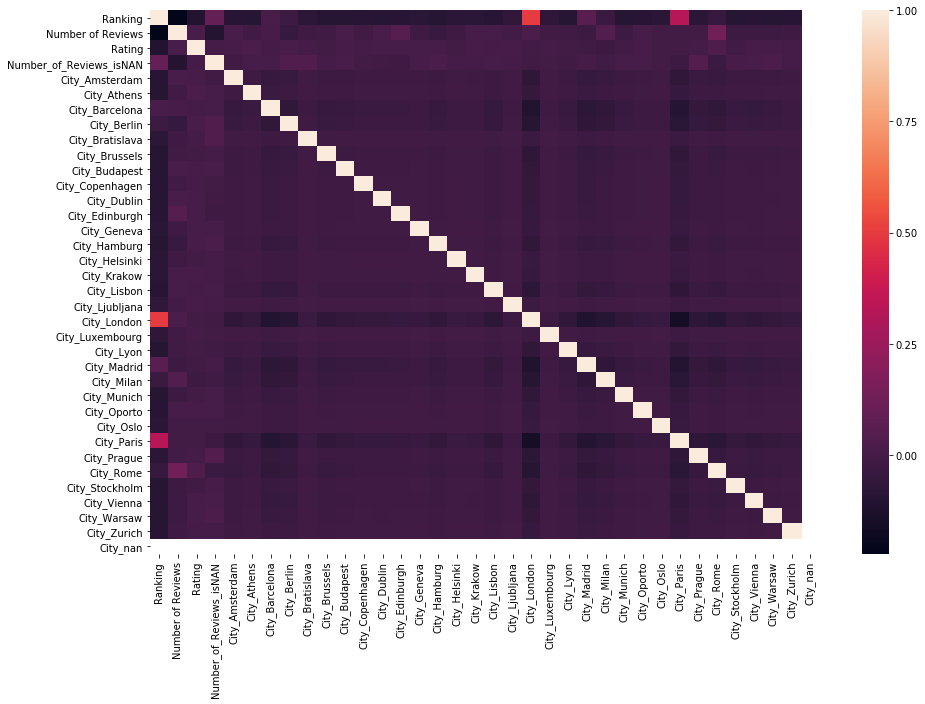

In [28]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [29]:
# в лондоне и париже самые крутые рестораны

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [30]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [31]:
def cousine2list(in_str): # функция для предобработки сведений о кухне
    #if in_str.isnan:
    #    return np.nan
    #else:
    return list(in_str[1:-1].replace("'", '').split(", "))

# Построение графиков
def get_gr(df, col, ttl):
    df[col].value_counts(ascending=True).plot(kind='barh', title=ttl)

In [32]:
# fill0=1,2, 3 варианты заполнения Nan 0, mean(sample), mean
# LE=False True добавлять или нет LabelEncoder

# тут находится все обработка входящих данных
def preproc_data(df_input,fill0=0,LE=True):        
    df_output = df_input.copy()
    
    # Выполняем такие операции по всем параметрам
    # ################### 1. Предобработка ############################################################## 
    # сохраним информацию о пропусках чтобы не потерять
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    # ################### 3. Encoding ##############################################################  
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    
    # убираем ненужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    df_output['Number of Reviews'].fillna(0, inplace=True)
    
    
    # #########################################################################################
    # обработка 'Price Range
    df_output['NaN_Price Range'] = pd.isna(df_output['Price Range']).astype('float64')   
    price_collection = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].replace(to_replace=price_collection)    
    col='Price Range'    
    if fill0==1:
        df_output[col].fillna(0, inplace=True)
    elif fill0==2:
        mean_sample0 = df_output[df_output["sample"]==0][col].mean()
        mean_sample1 = df_output[df_output["sample"]==1][col].mean()    
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==0),col]=mean_sample0
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==1),col]=mean_sample1
    elif fill0==3:
        mean_sample = df_output[col].mean()
        df_output.loc[(df_output[col].isna()),col]=mean_sample
       
    # #########################################################################################
    # Cuisine Style - предобработка
    df_output['NaN_Cuisine Style'] = pd.isna(df_output['Cuisine Style']).astype('float64')
    df_output["Cuisine Style"]=df_output["Cuisine Style"].fillna("['Cuisine_no_data']")          
    
    # закодируем значения в переменной до их преобразования
    # вариант интеллектуальной кодировки, показался не нужным
    if LE==True:
        le = LabelEncoder()
        le.fit(df_output['Cuisine Style'])
        df_output['code_Cuisine Style'] = le.transform(df_output['Cuisine Style'])
                
    #преобразуем Cuisine Style в листы
    df_output["Cuisine Style"]=df_output["Cuisine Style"].apply(cousine2list)  
    # обработка 'Cuisine Style'из листов в dummies
    mlb = MultiLabelBinarizer()
    df_dummies = pd.DataFrame(mlb.fit_transform(df_output["Cuisine Style"]),columns=mlb.classes_, index=df_output.index)        
    dummies = list(df_dummies.columns)
    df_output = pd.concat([df_output, df_dummies], axis=1) 
    
    df_output["Number of Cuisines"]=df_output["Cuisine Style"].apply(lambda x: len(x))
    
    # #########################################################################################      
    # Number of Reviews обработка
    df_output['NaN_Number of Reviews'] = pd.isna(df_output['Number of Reviews']).astype('float64')    
    
    # #########################################################################################      
    # Reviews обработка
    # заменим nan на ' '
    df_output["Reviews"] = df_output["Reviews"].str.replace("nan", "' '")
    # заменим пустые строки конструкцией
    df_output["Reviews"].fillna("[[], []]", inplace=True)
    # интерпритируем строку питона
    df_output["Reviews"] = df_output["Reviews"].apply(lambda x: ast.literal_eval(x))
    # переведем текст в дату
    df_output["Reviews Dates"] = df_output["Reviews"].apply(
        lambda x: [datetime.strptime(d, "%m/%d/%Y") for d in x[1]])    
    df_output["Reviews Dates"]=df_output["Reviews Dates"].apply(lambda x: x if (len(x)>=1) else [np.nan])
    # упорядочиваем данные по убыванию
    df_output["Reviews Dates"] = df_output["Reviews Dates"].apply(
        lambda x: [x[i] for i in [1, 0]]
        if ((len(x) > 1) and (x[1] > x[0])) else x)
    df_output.drop("Reviews", axis = 1, inplace=True)
    
    
    # Reviews Dates - создание новых признаков
    # разница дней отзывов
    df_output["Reviews Dates Diff"] = df_output["Reviews Dates"].apply(
        lambda x: (x[0] - x[1]).days if len(x) > 1 else np.nan)
    
    # сохраним информацию о пропусках чтобы не потерять
    df_output['NaN_Reviews Dates Diff'] = pd.isna(df_output['Reviews Dates Diff']).astype('float64')
    
    #заменяем средними значениями пропуски в Reviews Dates Diff
    col='Reviews Dates Diff'
    if fill0==1:
        df_output[col].fillna(0, inplace=True)
    elif fill0==2:
        mean_sample0 = df_output[df_output["sample"]==0][col].mean()
        mean_sample1 = df_output[df_output["sample"]==1][col].mean()    
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==0),col]=mean_sample0
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==1),col]=mean_sample1
    elif fill0==3:
        mean_sample = df_output[col].mean()
        df_output.loc[(df_output[col].isna()),col]=mean_sample   
                
    # Last Review Date дата последнего отзыва относительно сегодня
    LRD = datetime(2020,10,10) # сегодня
    df_output["Last Review Date"] = df_output["Reviews Dates"].apply(
        lambda x: (LRD-x[0]).days if len(x)>1 else np.nan if (pd.isnull(x)) else (LRD-x[0]).days)                
    
    # сохраним информацию о пропусках чтобы не потерять
    df_output['NaN_Last Review Date'] = pd.isna(df_output['Last Review Date']).astype('float64')
    
    #заменяем средними значениями пропуски в Last Review Date num
    col="Last Review Date"
    if fill0==1:
        df_output[col].fillna(0, inplace=True)
    elif fill0==2:
        mean_sample0 = df_output[df_output["sample"]==0][col].mean()
        mean_sample1 = df_output[df_output["sample"]==1][col].mean()    
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==0),col]=mean_sample0
        df_output.loc[(df_output[col].isna())&(df_output["sample"]==1),col]=mean_sample1
    elif fill0==3:
        mean_sample = df_output[col].mean()
        df_output.loc[(df_output[col].isna()),col]=mean_sample        
                    
    df_output.drop("Reviews Dates", axis = 1, inplace=True)
    
    # #########################################################################################      
    # Ranking обработка, стандартизация, добавление новых признаков

    mean_Ranking_on_City0 = df_output[df_output["sample"]==0].groupby(['City'])['Ranking'].mean()
    max_Ranking_on_City0 = df_output[df_output["sample"]==0].groupby(['City'])['Ranking'].max()
    count_Restorant_in_City0 = df_output[df_output["sample"]==0]['City'].value_counts(ascending=False)
    
    mean_Ranking_on_City1 = df_output[df_output["sample"]==1].groupby(['City'])['Ranking'].mean()
    max_Ranking_on_City1 = df_output[df_output["sample"]==1].groupby(['City'])['Ranking'].max()
    count_Restorant_in_City1 = df_output[df_output["sample"]==1]['City'].value_counts(ascending=False)    
    
    df_output.loc[df_output["sample"]==0,'max_Ranking_on_City'] = df_output[df_output["sample"]==0]['City'].apply(lambda x: max_Ranking_on_City0[x])
    df_output.loc[df_output["sample"]==0,'mean_Ranking_on_City'] = df_output[df_output["sample"]==0]['City'].apply(lambda x: mean_Ranking_on_City0[x])
    df_output.loc[df_output["sample"]==0,'count_Restorant_in_City'] = df_output[df_output["sample"]==0]['City'].apply(lambda x: count_Restorant_in_City0[x])    
    
    df_output.loc[df_output["sample"]==1,'max_Ranking_on_City'] = df_output[df_output["sample"]==1]['City'].apply(lambda x: max_Ranking_on_City1[x])            
    df_output.loc[df_output["sample"]==1,'mean_Ranking_on_City'] = df_output[df_output["sample"]==1]['City'].apply(lambda x: mean_Ranking_on_City1[x])
    df_output.loc[df_output["sample"]==1,'count_Restorant_in_City'] = df_output[df_output["sample"]==1]['City'].apply(lambda x: count_Restorant_in_City1[x])
    
    # #########################################################################################      
    # City обработка, добавление новых признаков            
    df_output['NaN_City'] = pd.isna(df_output['City']).astype('float64')  
    
    # добавляем информацию о городах
    dict_Сity_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
    #df_output['Сity_population'] = df_output["City"].replace(to_replace=dict_Сity_population)
    df_output['Сity_population'] = df_output["City"].apply(lambda x: dict_Сity_population[x])    
    
    # соотношение города и столицы страны
    dict_Сity_capital = {    'London': 1,    'Paris': 1,    'Madrid': 1,    'Barcelona': 0,    'Berlin': 1,
                             'Milan': 0,    'Rome': 1,    'Prague': 1,    'Lisbon': 1,    'Vienna': 1,    'Amsterdam': 1,    'Brussels': 1,
                             'Hamburg': 0,    'Munich': 0,    'Lyon': 0,    'Stockholm': 1,    'Budapest': 1,    'Warsaw': 1,    'Dublin': 1,
                             'Copenhagen': 1,    'Athens': 1,    'Edinburgh': 1,    'Zurich': 1,    'Oporto': 0,    'Geneva': 1,    'Krakow': 0,
                             'Oslo': 1,    'Helsinki': 1,    'Bratislava': 1,    'Luxembourg': 1,    'Ljubljana': 1}
    df_output['Capital'] = df_output['City'].apply(lambda x: dict_Сity_capital[x])
    
    # соотношение города и страны
    dict_Сity_coutry = {    'London': 'UK',    'Paris': 'FR',    'Madrid': 'ESP',    'Barcelona': 'ESP',    'Berlin': 'GER',
                            'Milan': 'IT',    'Rome': 'IT',    'Prague': 'Czech',    'Lisbon': 'PORT',    'Vienna': 'Austria',    'Amsterdam': 'Nederlands',
                            'Brussels': 'BELG',    'Hamburg': 'GER',    'Munich': 'GER',    'Lyon': 'FR',    'Stockholm': 'Sweden',   'Budapest': 'Hungary',
                            'Warsaw': 'PL',    'Dublin': 'Ireland',    'Copenhagen': 'Denmark',    'Athens': 'Greece',    'Edinburgh': 'Schotland',    'Zurich': 'Switzerland',
                            'Oporto': 'PORT',    'Geneva': 'Switzerland',    'Krakow': 'PL',    'Oslo': 'Norway',    'Helsinki': 'Finland',    'Bratislava': 'Slovakia',
                            'Luxembourg': 'Luxembourg',    'Ljubljana': 'Slovenija'    }
    df_output['Country'] = df_output['City'].apply(lambda x: dict_Сity_coutry[x])
    
    #колличетство ресторанов в стране
    df_tmp = df_output['Country'].value_counts()
    df_output['Rest_Count_Country'] = df_output['Country'].apply(lambda x: df_tmp[x])

    # вариант интеллектуальной кодировки, показался не нужным LE=False
    if LE==True:
        le = LabelEncoder()
        le.fit(df_output['City'])
        df_output['code_City'] = le.transform(df_output['City'])        
    
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True, drop_first=False)                                               
    df_output = pd.get_dummies(df_output, columns=[ 'Country',], dummy_na=True, drop_first=False)                                               
   
    # ################### 4. Feature Engineering ####################################################
     
    df_output['norm_Ranking_on_max_mean'] = (df_output['Ranking'] - df_output['mean_Ranking_on_City']) / (df_output['max_Ranking_on_City']-df_output['mean_Ranking_on_City'])
    df_output['norm_Ranking_on_max'] = (df_output['Ranking']) / (df_output['max_Ranking_on_City'])    
    df_output['norm_Population_on_Rest'] = df_output['Сity_population']/df_output['count_Restorant_in_City']
    df_output['norm_Ranking_on_Population'] = (df_output['Ranking']) / (df_output['Сity_population'])
        
                    
    #PolynomialFeatures
    #df_output["Cuisines_Price"]=df_output["Number of Cuisines"]*df_output['Price Range']
    #df_output["temp2"]=df_output["Number of Reviews"]*df_output['Reviews Dates Diff']
    #df_output["temp3"]=df_output["Number of Reviews"]*df_output['Number of Cuisines']

    #pf = PolynomialFeatures(2)
    #poly_features = pf.fit_transform(df[['col1', 'col2']])
    #df_pf=pd.DataFrame(poly_features,columns=["1", "a", "b", "a^2", "ab", "b^2"])
    #df = pd.concat([df, df_pf], axis=1)

    # ################### 5. Clean #################################################### 
    Nan_cols = ['NaN_Price Range', 'NaN_Number of Reviews', 'NaN_Cuisine Style', 'NaN_City',  'NaN_Reviews Dates Diff', 'NaN_Last Review Date']
    for col in Nan_cols:
        #display(df_output[col].sum())
        if df_output[col].sum()<len(df_output)/100.0:
            df_output.drop(col, axis = 1, inplace=True)
    
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

- Да, было бы хорошо

## Результат, следующие параметры были добавлены или проведены соответствующие изменения с данными:

    - 'NaN_Price Range'
    - Price Range:{'$': 1, '$$ - $$$': 2, '$$$$': 3}
    - 'NaN_Cuisine Style'
    - 'Cuisine Style' to dummies
    - "Number of Cuisines"
    - 'NaN_Number of Reviews'
    - "Reviews Dates Diff" (разница между днями двух отзывов)        
    - "Last Review Date" - время последнего отзыва
    - 'NaN_Last Review Date'
    - 'max_Ranking_on_City'
    - 'mean_Ranking_on_City'
    - 'count_Restorant_in_City'
    - 'Rest_Count_Country'
    - 'NaN_City' (столбец удален)
    - 'Сity_population'
    - 'Country' to dummies
    - 'Capital'
    - 'City' todummies
    - 'norm_Ranking_on_max_mean'
    - 'norm_Ranking_on_max'
    - 'norm_Population_on_Rest'
    - 'norm_Ranking_on_Population'

#### Запускаем и проверяем что получилось

In [33]:
df_preproc = preproc_data(data,fill0=3,LE=False)
df_preproc.sample(10)
df_preproc.info()
display("number of NaNs {}".format(df_preproc.isna().sum().sum()))

df_preproc.drop("Rest_Count_Country", axis = 1, inplace=True)
#df_preproc['Last Review Date'][df_preproc['Rating'] == 4].hist(bins=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 204 entries, Ranking to norm_Ranking_on_Population
dtypes: float64(17), int64(131), uint8(56)
memory usage: 59.1 MB


'number of NaNs 0'

In [34]:
#get_gr(df_preproc,'Country', 'Распределение целевой переменной')

In [35]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [36]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
# Сам ML

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)100 1 -1
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s


MAE: 0.19952687499999996


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


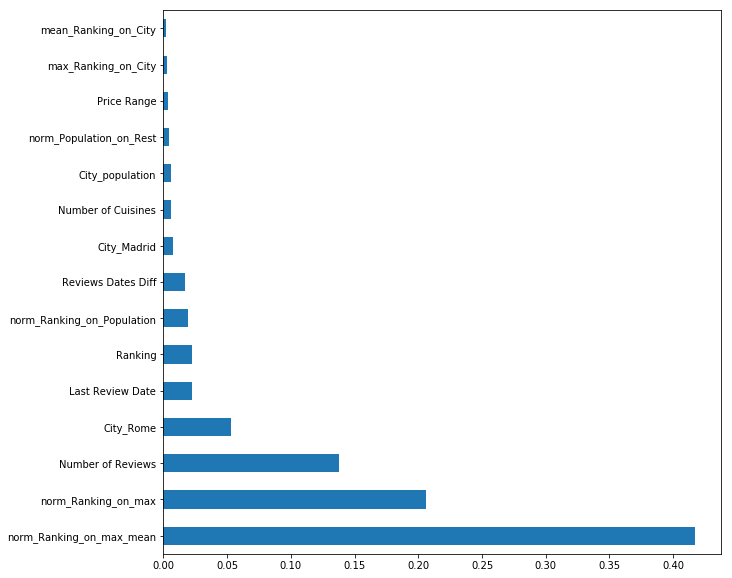

In [37]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

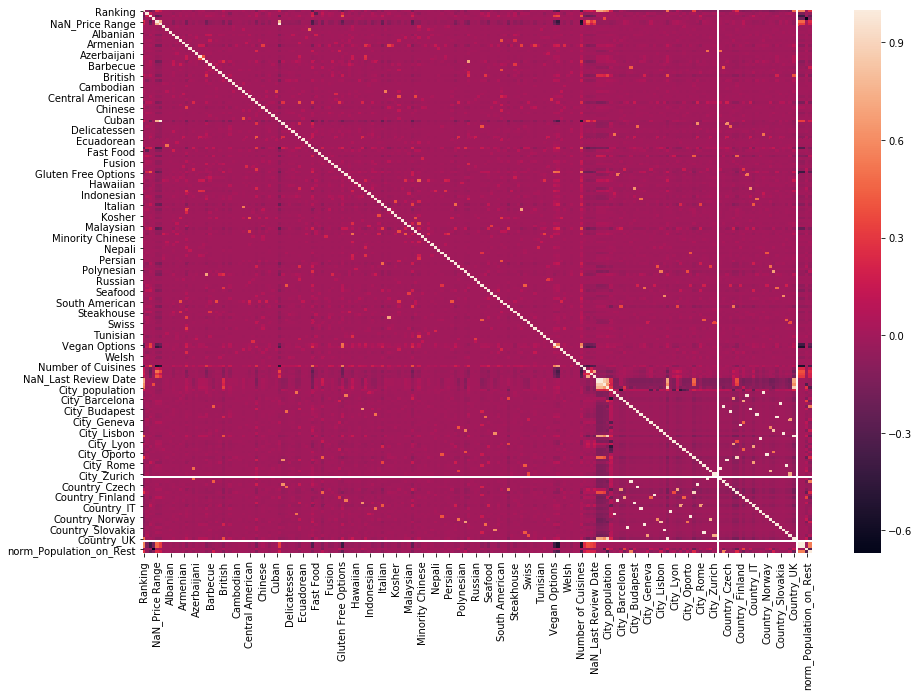

In [38]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_preproc.drop(['sample'], axis=1).corr(),)

# Submission
Если все устраевает - готовим Submission на кагл

In [39]:
test_data.sample(10)
test_data = test_data.drop(['Rating'], axis=1)
display(sample_submission)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [40]:
predict_submission = model.predict(test_data)
predict_submission = np.round(predict_submission*2)/2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [42]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# Выводы

 - познакомился с данными.
 - обработал данные для ML (EDA, FE для ML). 
 - MAE несколько улучшилось по сравнению с baseline (~0.05 MAE пункта).
 - Нужно более детально настраивать модель, например, можно попробовать убрать малоинформативные параметры, например, типы кухонь, которые редко встречаются. 
 - Отзывы не были проанализированы вовсе. Эмоциональный окрас отзывов их положительная или отрицательная оценка могли бы также помочь ML. 
 - Мне не совсем понравилось предложение baseline писать все в одной функции. Это удобно для тестирования, так, как быстро можно перезапустить функцию и провести тест, но это не удобно для EDA.
 - 'Сity_population', 'Country' to dummies, 'Capital' внешние параметры значительно улучшают модель.
 - Интересно, что один из самых важных параметров, это ранг ресторана и ревью пользователей. 
 - Так как оценки выставляются с точностью до 0,5, то результат предсказаний, также округлялся до 0,5, используя следующую процедуру: predict_submission = np.round(predict_submission*2)/2
 - Добавил возможность выбора для сравнения заполнение nan нулями, средними значениями по всем данным и средним для данных теста и тренировки.
 - В целом модель стала лучше работать по сравнению с baseline, видны недостатки и пути дальнейшего улучшения. 
 
